# TMDB Consolidation, Processing, and EDA
**Author:** Michael McCann <br>
**Last Updated:** 13 May 2022


<u>Overview:</u> <br>
Our [API call](https://github.com/msmccann10/PP-movie-database-and-analysis/blob/main/02_TMDB_API_Pull.ipynb) resulted in 21 CSVs for each year in which we were interested. However, to do any analysis we will need to pull these together into one DataFrame. We will also take an initial look at some of the TMDB data.

<u>Tasks:</u><br> 
- Merge TMDB data into one DataFrame
- Light cleaning for initial EDA
 - additional cleaning and column selection will be done prior to database creation.
- Save merged DataFrame, remove individual CSVs
- Initial EDA

<u>Other:</u><br>
NA


## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

## Load and Merge Dataframes
Load the results from our API call (years 2000 - 2021) and concatenate them into one DataFrame.

### Merge CSVs
**Note:** This section is commented out and remains for documentation purposes. After running thie script we save the merged DataFrame and delete the individual CSVs. See below to load in the merged DF. 

In [2]:
# YEARS = list(range(2000,2022))
# FOLDER = "data/"

# tmdb_merged = pd.DataFrame({})

# for YEAR in YEARS:
#     filepath = f"{FOLDER}final_tmdb_data_{YEAR}.csv.gz"
#     temp = pd.read_csv(filepath)
#     tmdb_merged = pd.concat([tmdb_merged, temp], ignore_index = True)
    
#     print(f'Year {year} added {temp.shape[0]} new rows to our dataframe. New Total: {tmdb_merged.shape[0]}')
#     print('-----')

### Remove Individual CSVs
Our individual csv.gz files have been made into a single merged csv.gz file. We do not need to keep the single csv.gz files as they are just taking up extra space and can be deleted. 

**Note:** This section is commented out to keep anyone from deleting files they might want to keep. Only run if you are willing/able to remove the non-merged csv files.

In [3]:
# # os.listdir("data/")

# for YEAR in YEARS:
#     if os.path.exists(f"{FOLDER}final_tmdb_data_{YEAR}.csv.gz"):
#         os.remove(f"{FOLDER}final_tmdb_data_{YEAR}.csv.gz")
#         print(f'file {FOLDER}final_tmdb_data_{YEAR}.csv.gz removed')
#     else:
#         print(f'file {FOLDER}final_tmdb_data_{YEAR}.csv.gz does not exist')

### Cleaning
Initial Cleaning prior to saving the DataFrame.

**Note:** This sections have been commented out as they were done PRIOR to saving the DataFrame. 

In [4]:
# display(tmdb_merged.head())
# print('\n')
# tmdb_merged.info()

In [5]:
# # Each DF loaded in has a first column with an IMDB ID equal to zero. 
# # This is from creating the file to save the API and should be removed. 
# tmdb_merged = tmdb_merged[tmdb_merged['imdb_id'] != '0']

In [6]:
# # Checking the certifications as that was one of the columns we were missing.
# tmdb_merged['certification'].unique()

In [7]:
# # Clean up the certifications
# replace_nr = {'Unrated':'UR', 'Not Rated': 'NR', '10':'NR', '-': 'NR',
#         'ScreamFest Horror Film Festival': 'NR'} 
# tmdb_merged['certification'] = tmdb_merged['certification'].str.strip()
# tmdb_merged['certification'] = tmdb_merged['certification'].replace(replace_nr)

In [8]:
# # Clean up the 'belongs_to_collection' column to indicate if it does/does not belong in a collection.
# tmdb_merged['belongs_to_collection'] = tmdb_merged['belongs_to_collection'].notna().astype(int)

### Save Merged DataFrame
Save out the merged DataFrame for use in EDA, database creation, and modeling 

In [9]:
# Save out DF for use in other steps
# tmdb_merged.to_csv(f"data/tmdb_merged.csv.gz", compression="gzip", index=False)

# EDA

In [10]:
# Load in data
tmdb_merged = pd.read_csv("data/tmdb_merged.csv.gz")

In [11]:
# Make a copy for visualization purposes
tmdb_viz = tmdb_merged.copy()

In [12]:
# For this initial EDA we were asked to eliminate variables other than revenue, budget, and certification:
tmdb_merged = tmdb_merged[['imdb_id', 'revenue', 'budget', 'certification']]

In [13]:
# Our stakeholder has expressed an interest in seeing only 'rated' movies budgets/revenue for comparison.
nr = tmdb_viz['certification'] == 'NR'
unrated = tmdb_viz['certification'] == 'Unrated'
nc17 = tmdb_viz['certification'] == 'NC-17'

tmdb_viz = tmdb_viz[~(nr | unrated | nc17)]
tmdb_viz.dropna(subset= ['certification'], inplace = True)

In [14]:
# Lets see what our dataset has in terms of budget/revenue data
budget = tmdb_viz['budget'] > 0
revenue = tmdb_viz['revenue'] > 0
either = tmdb_viz[budget | revenue]

print(f'{budget.sum()} rows have budget information.')
print(f'{revenue.sum()} rows have revenue information.')
print(f'{either["imdb_id"].count()} rows have either budget OR revenue information.')

5096 rows have budget information.
4781 rows have revenue information.
6113 rows have either budget OR revenue information.


In [15]:
# Grab movies with either budget OR revenue information available.
tmdb_viz = tmdb_viz[budget | revenue]

### Viz: Distriubution by Rating

In [16]:
## Set certification to a categorical ordering
tmdb_viz['certification'] = pd.Categorical(tmdb_viz['certification'],
                                           ['G','PG','PG-13','R'])

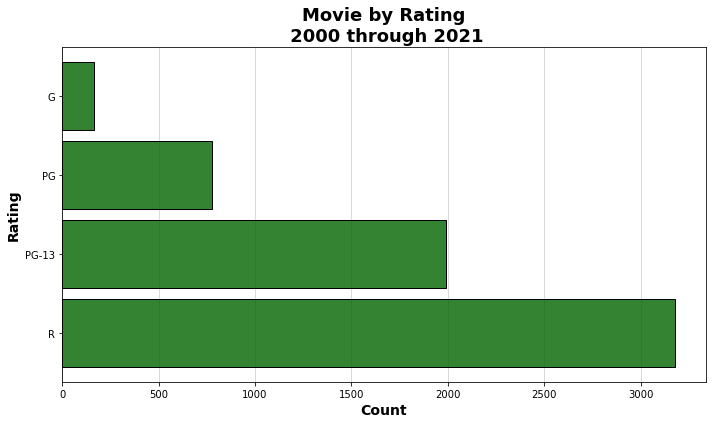

In [17]:
## Visualize Distribution by Rating
fig, ax = plt.subplots(figsize = (10,6))
sns.histplot(y = tmdb_viz['certification'], 
             color = "#006400", alpha = .8, shrink = .85)
plt.title('Movie by Rating\n 2000 through 2021', 
             fontsize = 18, weight = 'bold')
plt.xlabel('Count', fontsize=14, weight = 'semibold')
plt.ylabel('Rating',  fontsize=14, weight = 'semibold')
plt.grid(axis = 'x', alpha = .6)
ax.set_axisbelow(True)
fig.tight_layout()

### Viz: Mean Budget and Revenue by Rating

In [18]:
tmdb_viz.groupby('certification')['budget'].mean().sort_values(ascending = False)

certification
PG       4.210038e+07
PG-13    4.039237e+07
G        3.108911e+07
R        1.483547e+07
Name: budget, dtype: float64

In [19]:
tmdb_viz.groupby('certification')['revenue'].mean().sort_values(ascending = False)

certification
PG       1.267050e+08
PG-13    1.182030e+08
G        9.362867e+07
R        3.127063e+07
Name: revenue, dtype: float64

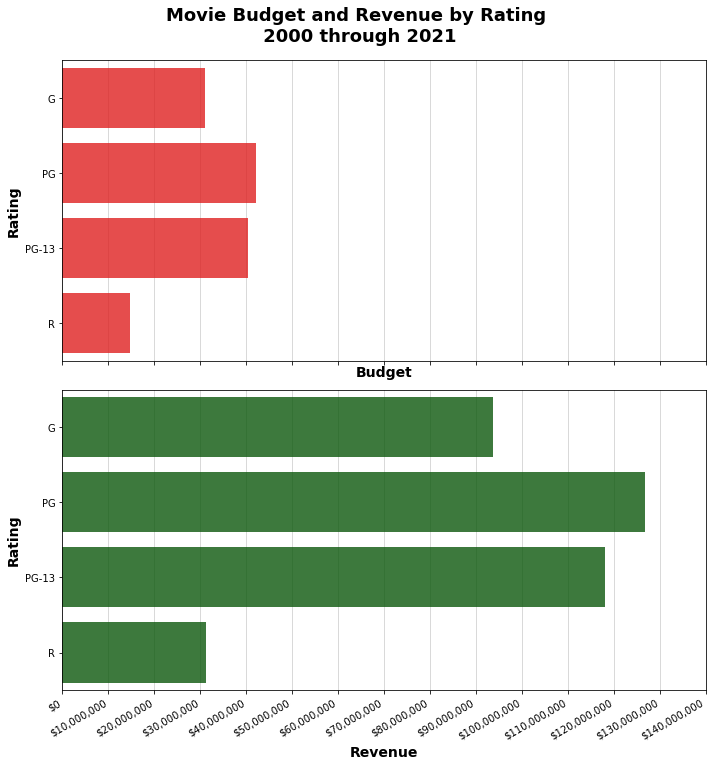

In [20]:
# Import string formatter for labels
from matplotlib.ticker import StrMethodFormatter

# Attempt 1 at comparing budget/revene on rating
fig, axes = plt.subplots(figsize=(10,10), nrows = 2, sharex = True)
plt.suptitle('Movie Budget and Revenue by Rating\n 2000 through 2021', 
             fontsize = 18, weight = 'bold', y = 1.06)
sns.barplot(data = tmdb_viz, x = 'budget', y = 'certification', 
            ci = None, color = "red", alpha = .8, ax = axes[0])
axes[0].set_xlabel('Budget', fontsize=14, weight = 'semibold')
axes[0].set_ylabel('Rating',  fontsize=14, weight = 'semibold')
sns.barplot(data = tmdb_viz, x = 'revenue', y = 'certification', 
            ci = None, color = "#006400", alpha = .8, ax = axes[1])
axes[1].set_xlabel('Revenue', fontsize=14, weight = 'semibold')
axes[1].set_ylabel('Rating',  fontsize=14, weight = 'semibold')
[ax.grid(axis = 'x', alpha = .6) for ax in axes]
[ax.set_axisbelow(True) for ax in axes]
axes[1].xaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))
plt.xlim(0,140000000)
plt.xticks(range(0, 141000000, 10000000),rotation = 30, ha = 'right')
fig.tight_layout()

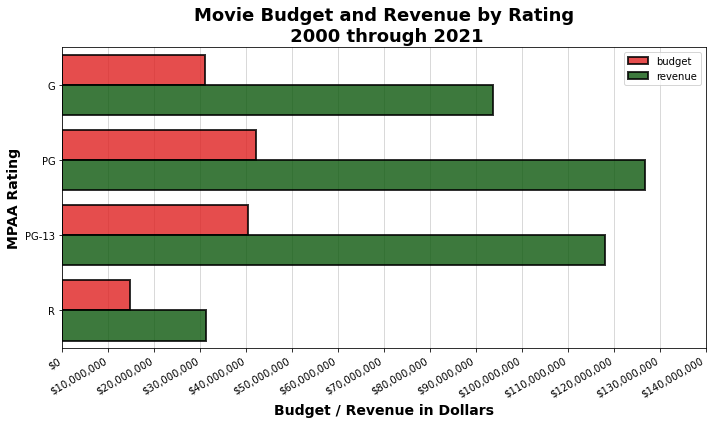

In [21]:
# Attempt 2 at comparing budget/revene on rating
palette ={"budget": "red", "revenue": "#006400"}

fig, axes = plt.subplots(figsize=(10,6), ncols = 1, nrows = 1)
sns.barplot(data = tmdb_viz.melt('certification', 
                                 value_vars = ['budget', 'revenue']),
            x = 'value', y = 'certification', hue = 'variable', 
            palette = palette, alpha = .8, ci = None, 
            edgecolor = 'black', lw = '2', ax = axes)
plt.title('Movie Budget and Revenue by Rating\n 2000 through 2021', 
             fontsize = 18, weight = 'bold')
plt.xlabel('Budget / Revenue in Dollars', fontsize=14, weight = 'semibold')
plt.ylabel('MPAA Rating',  fontsize=14, weight = 'semibold')
axes.grid(axis = 'x', alpha = .6, zorder = 0)
axes.set_axisbelow(True)
axes.xaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))
axes.legend(title = None, )
plt.xlim(0,140000000)
plt.xticks(range(0, 141000000, 10000000),rotation = 30, ha = 'right')
fig.tight_layout();

### Viz: Relationship between Budget and Revenue

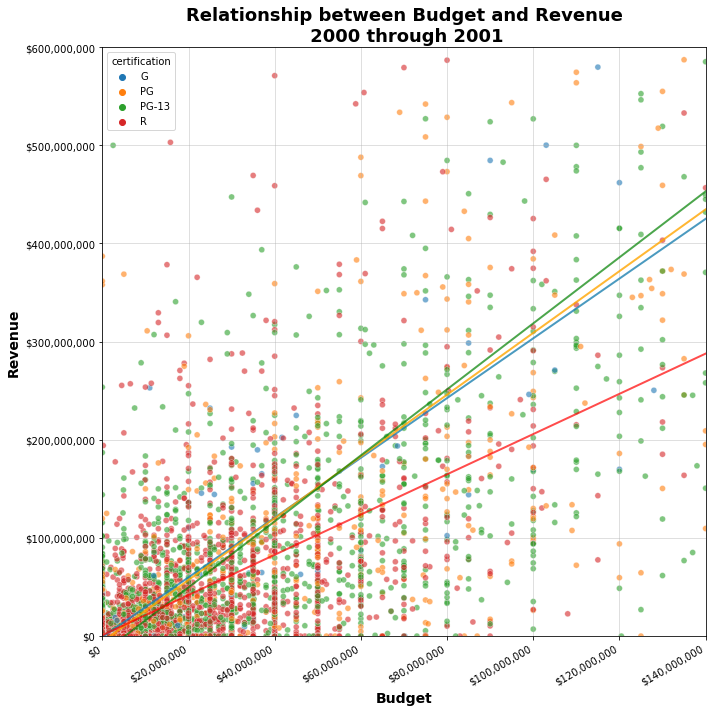

In [22]:
fig, ax = plt.subplots(figsize = (10,10))
sns.scatterplot(data = tmdb_viz, x = 'budget', y = 'revenue', hue = "certification", alpha = .6);
sns.regplot(data=tmdb_viz[tmdb_viz['certification'] == 'G'], x = 'budget', y = 'revenue', 
            scatter_kws={'s':0}, ci=None,
            line_kws={'color': '#1e81b0', 'lw' : 2, 'alpha' : .8})
sns.regplot(data=tmdb_viz[tmdb_viz['certification'] == 'PG'], x = 'budget', y = 'revenue', 
            scatter_kws={'s':0}, ci=None,
            line_kws={'color': "orange", 'lw' : 2, 'alpha' : .8})
sns.regplot(data=tmdb_viz[tmdb_viz['certification'] == 'PG-13'], x = 'budget', y = 'revenue', 
            scatter_kws={'s':0}, ci=None,
            line_kws={'color': "green", 'lw' : 2, 'alpha' : .7})
sns.regplot(data=tmdb_viz[tmdb_viz['certification'] == 'R'], x = 'budget', y = 'revenue', 
            scatter_kws={'s':0}, ci=None,
            line_kws={'color': "red", 'lw' : 2, 'alpha' : .7})
# sns.regplot(data=tmdb_viz[tmdb_viz['certification'] == 'NR'], x = 'budget', y = 'revenue', 
#             scatter_kws={'s':0}, ci=None,
#             line_kws={'color': "purple", 'lw' : 2, 'alpha' : .7})
# sns.regplot(data=tmdb_viz[tmdb_viz['certification'] == 'NC-17'], x = 'budget', y = 'revenue', 
#             scatter_kws={'s':0}, ci=None,
#             line_kws={'color': "brown", 'lw' : 2, 'alpha' : .7})
plt.title('Relationship between Budget and Revenue\n 2000 through 2001', 
             fontsize = 18, weight = 'bold')
plt.xlabel('Budget', fontsize=14, weight = 'semibold')
plt.ylabel('Revenue',  fontsize=14, weight = 'semibold')
ax.xaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))
plt.xlim(0,140000000)
plt.ylim(0,600000000)
plt.grid(alpha = .5)
plt.xticks(rotation = 30, ha = 'right')
fig.tight_layout()

# Appendix
Future graphics for further discovery.

In [23]:
tmdb_merged = pd.read_csv("data/tmdb_merged.csv.gz")

In [24]:
tmdb_merged.columns

Index(['imdb_id', 'adult', 'backdrop_path', 'belongs_to_collection', 'budget',
       'genres', 'homepage', 'id', 'original_language', 'original_title',
       'overview', 'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count', 'certification'],
      dtype='object')

In [25]:
# red_notice = tmdb_merged[tmdb_merged['imdb_id'] == 'tt7991608']
# red_notice['revenue']

In [26]:
tmdb_brett = tmdb_merged.copy()
tmdb_brett = tmdb_brett[tmdb_brett['revenue'] != 0]
tmdb_brett = tmdb_brett[tmdb_brett['budget'] != 0]

nr = tmdb_brett['certification'] == 'NR'
unrated = tmdb_brett['certification'] == 'Unrated'
nc17 = tmdb_brett['certification'] == 'NC-17'

tmdb_brett = tmdb_brett[~(nr | unrated | nc17)]
tmdb_brett.dropna(subset= ['certification'], inplace = True)

tmdb_brett['brett'] = tmdb_brett['revenue']/tmdb_brett['budget']
tmdb_brett.head()

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,...,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification,brett
3,tt0118694,0.0,/n4GJFGzsc7NinI1VeGDXIcQjtU2.jpg,0,150000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",http://www.wkw-inthemoodforlove.com/,843.0,cn,花樣年華,...,99.0,"[{'english_name': 'Cantonese', 'iso_639_1': 'c...",Released,"Feel the heat, keep the feeling burning, let t...",In the Mood for Love,0.0,8.1,1860.0,PG,85.699687
10,tt0120467,0.0,NaN,0,120000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 27, 'name...",NaN,19085.0,en,Vulgar,...,87.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Everyone loves a clown... some more than others.,Vulgar,0.0,5.5,40.0,R,0.124200
12,tt0120630,0.0,/t7aJ7hqsMLEoqBJk7yAXxcAVvcz.jpg,1,45000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",NaN,7443.0,en,Chicken Run,...,84.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,This ain't no chick flick. It's poultry in mot...,Chicken Run,0.0,6.7,3992.0,G,4.996324
15,tt0120753,0.0,/cXXxi0j9sXFt7LbeajuFoKFqWMu.jpg,0,8000000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 53, 'name...",NaN,318.0,en,The Million Dollar Hotel,...,122.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Everyone has something to hide.,The Million Dollar Hotel,0.0,5.9,247.0,R,0.013248
16,tt0120755,0.0,/8XaohdSqoBEWHhW40q2VTdMBrV0.jpg,1,125000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",NaN,955.0,en,Mission: Impossible II,...,123.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Expect the impossible again.,Mission: Impossible II,0.0,6.1,5266.0,PG-13,4.371105


In [27]:
red_notice = tmdb_brett[tmdb_brett['title'].str.contains('Red Notice')]

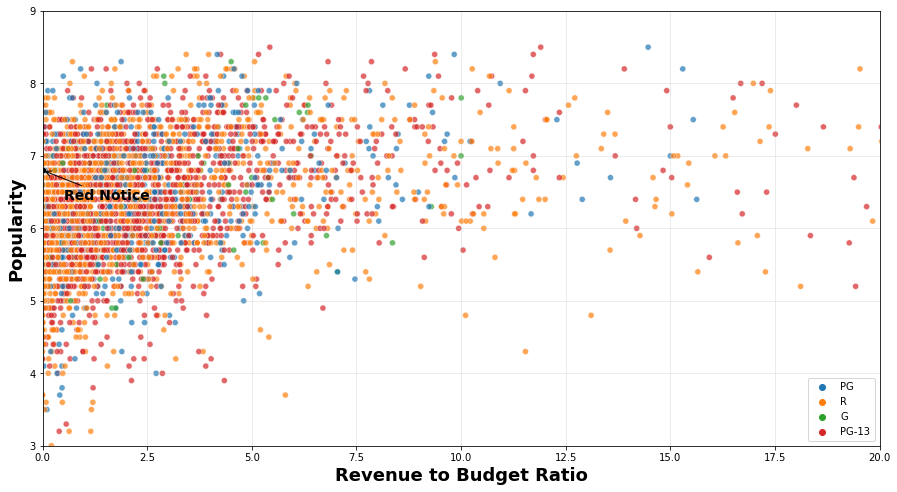

In [32]:
fig, ax = plt.subplots(figsize = (15,8))
sns.scatterplot(data = tmdb_brett, x = tmdb_brett['brett'], y = tmdb_merged['vote_average'],
               hue = 'certification', alpha = .7)
sns.scatterplot(data = tmdb_brett, x = red_notice['brett'], y = red_notice['vote_average'],
               color = 'k', marker = 'o')
plt.xlim(0, 20)
plt.ylim(3,9)
plt.grid(alpha = .3)
plt.ylabel('Popularity', size = 18, weight = 'semibold')
plt.xlabel('Revenue to Budget Ratio',size = 18, weight = 'semibold')
plt.annotate("Red Notice", xy = (red_notice['brett'], red_notice['vote_average']),
         xytext=(red_notice['brett']+.5, red_notice['vote_average']-.4), 
             arrowprops=dict(arrowstyle='->'), size = 14, weight = 'semibold');

In [29]:
drop_list=['adult', 'runtime', 'genres', 'release_date', 'backdrop_path', 'homepage', 
           'tagline', 'poster_path', 'original_title', 'id', 'video', 'overview', 
           'original_language', 'spoken_languages']

tmdb_brett.drop(columns = drop_list, inplace = True)


tmdb_brett.sort_values(by = ['brett'], ascending = False)
# .sort_values(tmdb_brett['brett'], ascending = False)

,imdb_id,belongs_to_collection,budget,popularity,production_companies,production_countries,revenue,status,title,vote_average,vote_count,certification,brett
18657,tt0893412,0,93.0,9.108,"[{'id': 1575, 'logo_path': None, 'name': 'Lewi...","[{'iso_3166_1': 'US', 'name': 'United States o...",2500000.0,Released,From Prada to Nada,5.5,279.0,PG-13,26881.720430
6798,tt0404802,0,90.0,11.236,"[{'id': 1512, 'logo_path': None, 'name': 'John...","[{'iso_3166_1': 'US', 'name': 'United States o...",1410778.0,Released,The Notorious Bettie Page,6.3,116.0,R,15675.311111
21803,tt1595656,0,112.0,9.916,"[{'id': 37145, 'logo_path': None, 'name': 'Bro...","[{'iso_3166_1': 'US', 'name': 'United States o...",587615.0,Released,To the Wonder,5.8,394.0,R,5246.562500
11366,tt1179904,1,215000.0,52.274,"[{'id': 3172, 'logo_path': '/kDedjRZwO8uyFhuHa...","[{'iso_3166_1': 'US', 'name': 'United States o...",194183034.0,Released,Paranormal Activity,6.0,4156.0,R,903.176902
32066,tt2309260,1,100000.0,13.689,"[{'id': 69581, 'logo_path': None, 'name': 'Tre...","[{'iso_3166_1': 'US', 'name': 'United States o...",42664410.0,Released,The Gallows,5.0,818.0,R,426.644100
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25407,tt2083231,0,15000000.0,6.411,"[{'id': 13498, 'logo_path': None, 'name': 'Mar...","[{'iso_3166_1': 'US', 'name': 'United States o...",1061.0,Released,Java Heat,5.6,65.0,R,0.000071
11626,tt0400426,0,30000000.0,9.656,"[{'id': 1063, 'logo_path': '/fpVBhNnopOZwGuF0g...","[{'iso_3166_1': 'DE', 'name': 'Germany'}, {'is...",743.0,Released,Far Cry,3.7,217.0,R,0.000025
8243,tt0429277,0,2000000.0,2.716,"[{'id': 92534, 'logo_path': None, 'name': 'Zyz...","[{'iso_3166_1': 'US', 'name': 'United States o...",30.0,Released,Zyzzyx Road,5.1,8.0,R,0.000015
10679,tt0859760,0,4002313.0,7.547,"[{'id': 6535, 'logo_path': None, 'name': 'Narr...","[{'iso_3166_1': 'MX', 'name': 'Mexico'}]",6.0,Released,To Rob a Thief,7.4,73.0,PG-13,0.000001
